1. Загружаем библиотеки и данные
   
- Импортируем библиотеки pandas и numpy для работы с данными, matplotlib и seaborn для визуализации, scikit-learn для обучения моделей;
- Загружаем данные из файла ebw_data.csv и выводим первые строки для ознакомления;
- Выводим статистику данных, чтобы понять распределение каждого признака.

In [7]:
# Импорт библиотек для анализа данных и визуализации
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт библиотек для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Загрузка данных
data = pd.read_csv('ebw_data.csv')

# Просмотр первых строк данных
display(data.head())

# Описание данных
display(data.describe())

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


2. Разведочный анализ данных

Проводим визуализацию распределений каждого признака и построение корреляционной матрицы. Создаем гистограммы для каждого признака, чтобы увидеть, как данные распределены, что поможет лучше понять структуру данных и выявить аномалии, если они есть. Затем строим тепловую карту корреляций между признаками, которая показывает взаимосвязи между ними. Корреляционная матрица с аннотациями числовых значений поможет определить, какие признаки могут быть связаны с целевыми переменными (Depth и Width).

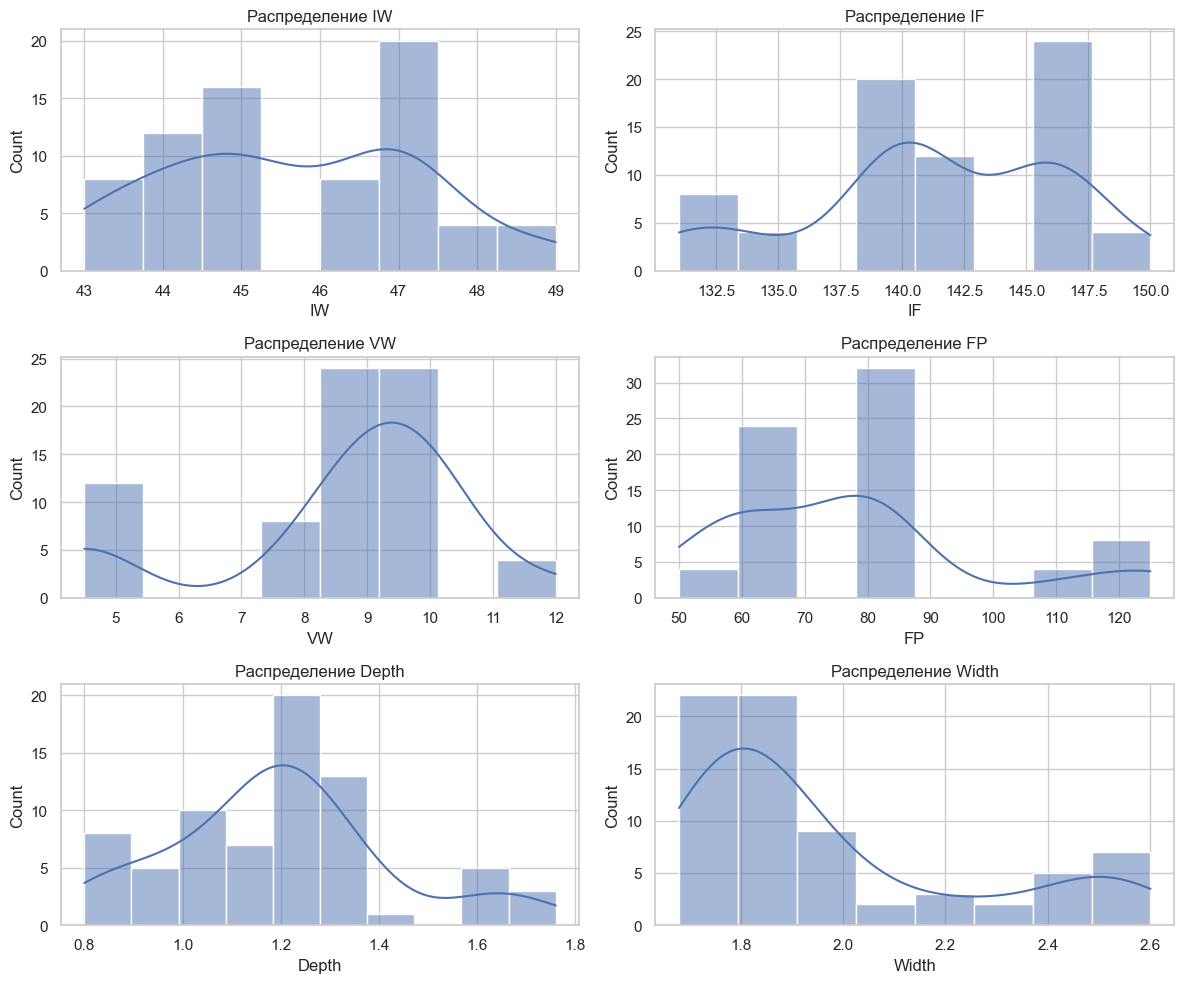

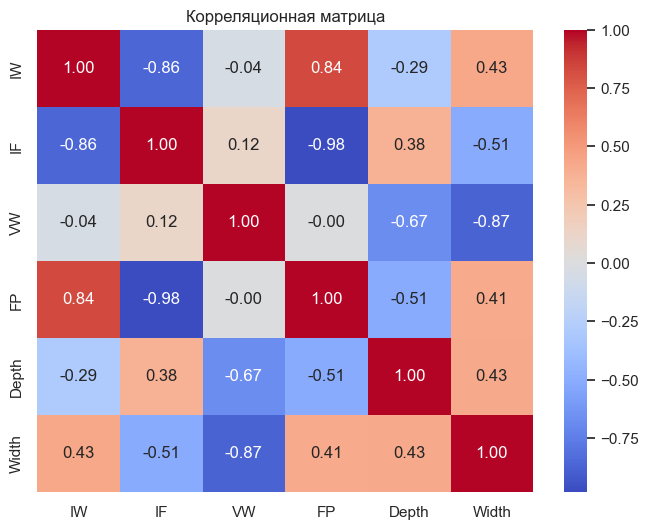

In [8]:
# Установка стиля для визуализации
sns.set(style="whitegrid")

# Визуализация распределения признаков
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']

for idx, column in enumerate(columns):
    sns.histplot(data[column], kde=True, ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_title(f'Распределение {column}')

plt.tight_layout()
plt.show()

# Корреляционная матрица
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

3. Предобработка данных

Разделяем данные на признаки (IW, IF, VW, FP) и целевые переменные (Depth и Width). Затем, с помощью StandardScaler, нормализуем признаки, чтобы каждый имел среднее значение 0 и стандартное отклонение 1, что поможет моделям быстрее и точнее обучиться. Затем, разделяем данные на обучающую и тестовую выборки (80% на обучение и 20% на тестирование). 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Разделение данных на признаки и целевые переменные
X = data[['IW', 'IF', 'VW', 'FP']]
y_depth = data['Depth']
y_width = data['Width']

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train_depth, y_test_depth = train_test_split(X_scaled, y_depth, test_size=0.2, random_state=42)
_, _, y_train_width, y_test_width = train_test_split(X_scaled, y_width, test_size=0.2, random_state=42)

4. Обучение и оценка моделей

Создаем и обучаем две модели (линейную регрессию и случайный лес) для предсказания Depth и Width. После обучения каждая модель оценивается по метрикам:
- MAE (средняя абсолютная ошибка) - средняя разница между реальными и предсказанными значениями;
- MSE (среднеквадратичная ошибка) - среднее квадрата ошибок, дающее большее влияние большим ошибкам;
- R² (коэффициент детерминации) - показывает, насколько хорошо модель объясняет вариативность целевой переменной (значение ближе к 1 говорит о высокой точности).

In [10]:
# Импорт моделей и метрик
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Определение моделей
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42)
}

# Функция для обучения и оценки моделей
def evaluate_model(model, X_train, X_test, y_train, y_test, target_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{target_name} - MAE: {mae:.3f}, MSE: {mse:.3f}, R2: {r2:.3f}")
    return predictions

# Оценка моделей для Depth
print("Predictions for Depth")
depth_predictions_results = {}
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    depth_predictions_results[model_name] = evaluate_model(model, X_train, X_test, y_train_depth, y_test_depth, "Depth")

# Оценка моделей для Width
print("\nPredictions for Width")
width_predictions_results = {}
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    width_predictions_results[model_name] = evaluate_model(model, X_train, X_test, y_train_width, y_test_width, "Width")

Predictions for Depth

Model: Linear Regression
Depth - MAE: 0.114, MSE: 0.022, R2: 0.615

Model: Random Forest Regressor
Depth - MAE: 0.069, MSE: 0.008, R2: 0.865

Predictions for Width

Model: Linear Regression
Width - MAE: 0.042, MSE: 0.002, R2: 0.977

Model: Random Forest Regressor
Width - MAE: 0.038, MSE: 0.002, R2: 0.979


Согласно полученным метрикам можно провести следующий анализ и вывод:

1. MAE (Средняя абсолютная ошибка):
Depth: MAE составляет 0.114 для линейной регрессии и 0.069 для случайного леса.
Width: MAE составляет 0.042 для линейной регрессии и 0.038 для случайного леса.
MAE показывает среднюю величину ошибок (в абсолютном значении) между предсказанными и реальными значениями. Чем меньше MAE, тем точнее модель.

2. MSE (Среднеквадратичная ошибка):
Depth: MSE составляет 0.022 для линейной регрессии и 0.008 для случайного леса.
Width: MSE составляет 0.002 для обеих моделей.
MSE учитывает квадраты ошибок, делая более значимыми крупные ошибки. Низкие значения MSE указывают на хорошие предсказания.

3. R² (Коэффициент детерминации):
Depth: R² составляет 0.615 для линейной регрессии и 0.865 для случайного леса.
Width: R² составляет 0.977 для линейной регрессии и 0.979 для случайного леса.
R² показывает, какую часть вариации целевой переменной модель может объяснить. Чем ближе значение к 1, тем лучше модель. Значение 0.865 для случайного леса при предсказании Depth и 0.979 для Width показывают, что случайный лес значительно точнее линейной регрессии, особенно для Depth.

Вывод: случайный лес лучше справляется с предсказанием как Depth, так и Width по всем трем метрикам, особенно для переменной Depth.
Линейная регрессия дает близкие результаты для Width, но уступает для Depth. Так как случайный лес показывает более высокую точность, выбираем его как основную модель для прогнозирования

5. Визуализация предсказанных и реальных значений

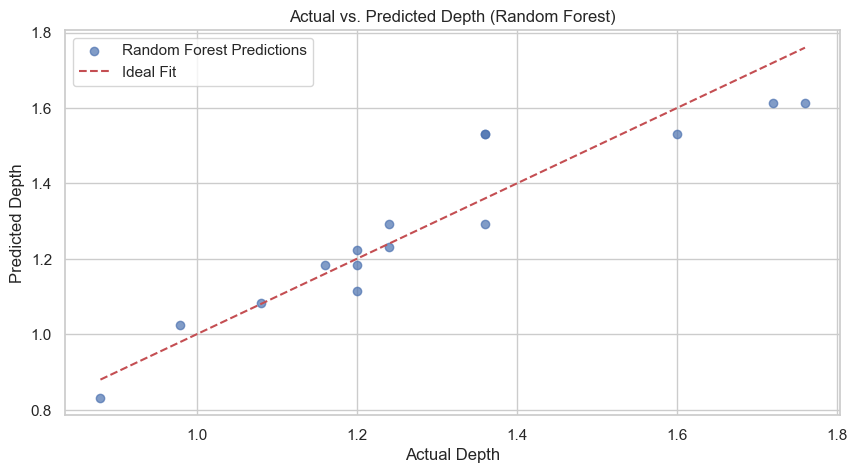

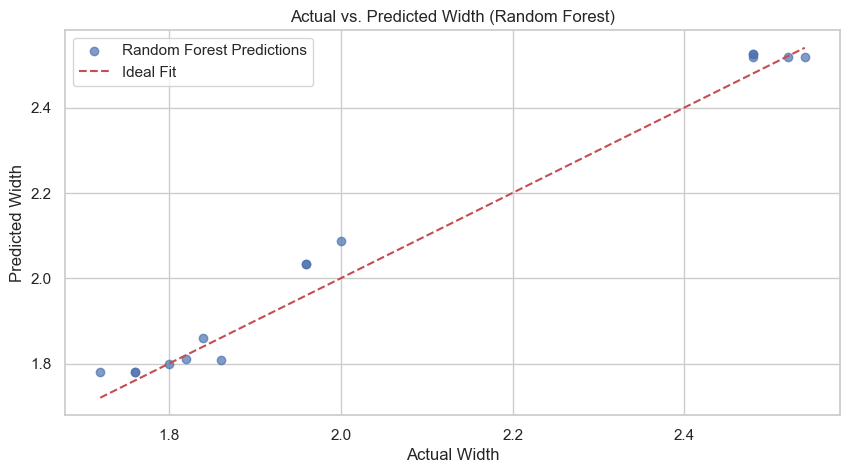

In [11]:
# Визуализация предсказанных и реальных значений для Depth и Width (случайный лес)
import matplotlib.pyplot as plt

# Depth (Random Forest)
plt.figure(figsize=(10, 5))
plt.scatter(y_test_depth, depth_predictions_results["Random Forest Regressor"], alpha=0.7, label='Random Forest Predictions')
plt.plot([min(y_test_depth), max(y_test_depth)], [min(y_test_depth), max(y_test_depth)], 'r--', label='Ideal Fit')
plt.xlabel("Actual Depth")
plt.ylabel("Predicted Depth")
plt.title("Actual vs. Predicted Depth (Random Forest)")
plt.legend()
plt.show()

# Width (Random Forest)
plt.figure(figsize=(10, 5))
plt.scatter(y_test_width, width_predictions_results["Random Forest Regressor"], alpha=0.7, label='Random Forest Predictions')
plt.plot([min(y_test_width), max(y_test_width)], [min(y_test_width), max(y_test_width)], 'r--', label='Ideal Fit')
plt.xlabel("Actual Width")
plt.ylabel("Predicted Width")
plt.title("Actual vs. Predicted Width (Random Forest)")
plt.legend()
plt.show()

График Depth:
- на графике точки предсказанных значений близки к пунктирной линии (идеальное совпадение), но есть некоторые отклонения.
В целом, модель случайного леса достаточно точно предсказывает Depth, хотя есть несколько точек, которые находятся дальше от линии, что указывает на небольшие ошибки в предсказании. Это приемлимо, учитывая, что R² для Depth не достигает 1.

График Width:
- на графике точки предсказанных значений практически идеально ложатся на линию, что указывает на очень высокую точность модели.
Значение R² близкое к 1 подтверждает, что модель случайного леса отлично предсказывает Width и учитывает все значимые зависимости для этой переменной.

Случайный лес хорошо справляется с предсказанием Width, демонстрируя высокую точность. Для значений Depth модель тоже показывает хорошие результаты, но есть некоторые погрешности.

Резюмируя проделанную работу, можно выделить следующие этапы.

1. Разведочный анализ данных:
- Проведено исследование распределения признаков и взаимосвязи между параметрами, чтобы лучше понять структуру данных.
Построена корреляционная матрица, чтобы выявить признаки, которые могут иметь наибольшее влияние на целевые переменные Depth и Width.

2. Обучение моделей:
- Проведено тестирование двух моделей регрессии: линейной регрессии и случайного леса.
Каждая модель оценивалась с помощью метрик MAE, MSE и R² для обеих целевых переменных.

3. Выбор модели случайного леса:
- Модель случайного леса показала лучшие результаты для обеих целевых переменных. Она превосходила линейную регрессию по всем метрикам, особенно при предсказании переменной Width.
Высокое значение R² для Width (0.979) показало, что модель точно предсказывает ширину сварного шва, а значение R² для Depth (0.865) подтвердило, что модель также справляется с предсказанием глубины.

4. Визуализация результатов:
- Визуализировали графики, сравнивающие предсказанные и реальные значения, что позволило наглядно оценить точность модели случайного леса.
Модель случайного леса продемонстрировала высокую точность для Width и хорошую точность для Depth.


Результаты и метрики модели случайного леса

Depth (Глубина):
- Средняя абсолютная ошибка (MAE): 0.069
- Среднеквадратичная ошибка (MSE): 0.008
- Коэффициент детерминации (R²): 0.865

Width (Ширина):
- Средняя абсолютная ошибка (MAE): 0.038
- Среднеквадратичная ошибка (MSE): 0.002
- Коэффициент детерминации (R²): 0.979


Эти метрики подтверждают, что модель случайного леса может с высокой точностью предсказывать размеры сварного шва при заданных параметрах сварки.